In [1]:
import os, sys
from os.path import dirname

root_path = os.path.abspath(os.getcwd())
if not root_path in sys.path: sys.path.insert(0, root_path)
    
print(sys.path)    

['D:\\GitWork\\ants_and_bees', 'C:\\opt\\miniconda3\\envs\\py37\\python37.zip', 'C:\\opt\\miniconda3\\envs\\py37\\DLLs', 'C:\\opt\\miniconda3\\envs\\py37\\lib', 'C:\\opt\\miniconda3\\envs\\py37', '', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\win32', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\win32\\lib', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\Pythonwin', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Morpheus\\.ipython']


In [2]:
import argparse

def parse_args(**args):
    parser = argparse.ArgumentParser(description='Luna Nodule Detection by PyTorch')
    parser.add_argument("--cfg", type=str, default="configs/config_train.yaml",
                        help="Configuration filename.")
    # return parser.parse_args(**args)          # for python
    return parser.parse_known_args(**args)    # for jupyter notebook

args, _ = parse_args()
print(args)

Namespace(cfg='configs/config_train.yaml')


In [3]:
from configs.config_train import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file(args.cfg)
cfg.freeze()
print(cfg)

DATA:
  ROOT_PATH: D:\GitWork\ants_and_bees\data\hymenoptera_data\
WORK:
  ROOT_PATH: D:\GitWork\ants_and_bees\


In [4]:
# Author: Morpheus Hsieh
# Ref: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division  

import copy
import numpy as np
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

plt.ion()   # interactive mode

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation

trans_norm = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225]
)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        trans_norm
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        trans_norm
    ]),
}

data_dir = os.path.join(cfg.DATA.ROOT_PATH)

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print('\nData transform: '); print(data_transforms);

print('\nImage dataset: '); print(image_datasets)

print('\nDataloaders: '); print(dataloaders)

print('\nDataset sizes: '); print(dataset_sizes)

print('\nClassnames: '); print(class_names)

print('\nDevice: '); print(device)


Data transform: 
{'train': Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'val': Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}

Image dataset: 
{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: D:\GitWork\ants_and_bees\data\hymenoptera_data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    

In [7]:
print(image_datasets['train'].__len__())
print(image_datasets['train'][1])

# print(image_datasets['val'].__len__())
# print(image_datasets['val'][1])

for i, traindata in enumerate(dataloaders['train']):
    print('i:',i)
    Data, Label = traindata
    print('data:', Data)
    print('Label:', Label)

244
(tensor([[[-0.7137, -0.7308, -0.6794,  ...,  0.8789,  0.8789,  0.8618],
         [-0.6623, -0.6452, -0.6452,  ...,  0.8789,  0.8618,  0.8618],
         [-0.6623, -0.6281, -0.5938,  ...,  0.8447,  0.7419,  0.8276],
         ...,
         [ 2.0263,  2.0434,  2.0605,  ...,  1.5639,  1.5468,  1.6667],
         [ 1.9407,  2.0263,  2.0434,  ...,  1.6495,  1.5810,  1.6838],
         [ 1.7180,  1.8550,  1.9407,  ...,  1.5982,  1.4954,  1.6495]],

        [[ 0.2927,  0.3452,  0.3452,  ...,  0.6429,  0.6254,  0.6078],
         [ 0.3102,  0.3803,  0.3627,  ...,  0.5553,  0.5728,  0.6078],
         [ 0.3627,  0.4328,  0.4328,  ...,  0.6078,  0.5203,  0.5728],
         ...,
         [ 1.9734,  2.0259,  2.0609,  ...,  1.5707,  1.5707,  1.6933],
         [ 1.9909,  2.0959,  2.1310,  ...,  1.7283,  1.6408,  1.7633],
         [ 1.7633,  1.9209,  2.0434,  ...,  1.6758,  1.5532,  1.6933]],

        [[-0.6541, -0.6367, -0.6367,  ...,  0.2173,  0.2522,  0.2348],
         [-0.5670, -0.5495, -0.5670,  ..

          [ 0.4439,  0.1302, -0.3404,  ...,  1.1759,  1.3328,  1.1759]]]])
Label: tensor([0, 1, 0, 0])
i: 15
data: tensor([[[[ 0.1254,  0.1254,  0.1254,  ..., -0.2684, -0.2856, -0.2856],
          [ 0.1768,  0.1426,  0.1426,  ..., -0.2856, -0.2856, -0.2856],
          [ 0.1939,  0.1939,  0.1939,  ..., -0.2684, -0.2684, -0.2513],
          ...,
          [ 1.7352,  1.4954,  1.4783,  ...,  0.3309,  0.3309,  0.3481],
          [ 1.7352,  1.5125,  1.4954,  ...,  0.3138,  0.3309,  0.3309],
          [ 1.7523,  1.5468,  1.4954,  ...,  0.3309,  0.3309,  0.3309]],

         [[-0.0574, -0.0924, -0.0924,  ..., -0.1800, -0.1800, -0.1800],
          [-0.0049, -0.0574, -0.0399,  ..., -0.1975, -0.1800, -0.1800],
          [ 0.0126,  0.0126,  0.0126,  ..., -0.1625, -0.1625, -0.1450],
          ...,
          [ 1.5182,  1.2556,  1.2381,  ...,  0.4153,  0.4153,  0.4328],
          [ 1.5357,  1.3081,  1.2556,  ...,  0.3978,  0.4153,  0.4153],
          [ 1.5532,  1.3431,  1.2556,  ...,  0.4153,  0.4153,

          [-1.4036, -1.3339, -1.4210,  ...,  0.8099,  1.1585,  1.1934]]]])
Label: tensor([0, 0, 1, 0])
i: 29
data: tensor([[[[-0.3369, -0.3198, -0.3198,  ..., -0.1314, -0.1314, -0.1143],
          [-0.3369, -0.3198, -0.3198,  ..., -0.1486, -0.1314, -0.1143],
          [-0.3198, -0.3198, -0.3198,  ..., -0.1657, -0.1486, -0.1314],
          ...,
          [-0.3712, -0.3541, -0.3198,  ..., -0.2171, -0.1999, -0.1999],
          [-0.3541, -0.3369, -0.3369,  ..., -0.1828, -0.1657, -0.1828],
          [-0.3369, -0.3369, -0.3369,  ..., -0.1486, -0.1486, -0.1657]],

         [[ 0.6429,  0.6604,  0.6604,  ...,  0.7654,  0.7654,  0.7829],
          [ 0.6429,  0.6604,  0.6604,  ...,  0.7479,  0.7654,  0.7829],
          [ 0.6604,  0.6604,  0.6604,  ...,  0.7304,  0.7479,  0.7654],
          ...,
          [ 0.6254,  0.6429,  0.6779,  ...,  0.7304,  0.7654,  0.7829],
          [ 0.6604,  0.6604,  0.6604,  ...,  0.7479,  0.7654,  0.7654],
          [ 0.6779,  0.6604,  0.6604,  ...,  0.7654,  0.7654,

data: tensor([[[[ 1.3413,  1.3413,  1.3242,  ...,  1.5297,  1.5125,  1.4783],
          [ 1.2899,  1.3242,  1.2899,  ...,  1.6495,  1.5468,  1.4612],
          [ 1.2899,  1.2728,  1.2728,  ...,  1.7009,  1.5639,  1.4612],
          ...,
          [ 1.0844,  0.9817,  1.1187,  ..., -1.3473, -1.1075, -0.5938],
          [ 1.5468,  1.3755,  1.2899,  ..., -0.6109, -0.4397, -0.3027],
          [ 1.6153,  1.5982,  1.7352,  ..., -0.1143,  0.5193,  0.4679]],

         [[ 1.0980,  1.0980,  1.0980,  ...,  1.2731,  1.2381,  1.2031],
          [ 1.0455,  1.0805,  1.0980,  ...,  1.4307,  1.3081,  1.2031],
          [ 1.1856,  1.1681,  1.1506,  ...,  1.5357,  1.3782,  1.2206],
          ...,
          [ 1.0805,  0.9755,  1.0980,  ..., -1.5630, -1.3354, -1.0553],
          [ 1.5357,  1.3431,  1.2381,  ..., -1.1429, -0.9328, -0.6176],
          [ 1.6583,  1.6232,  1.7458,  ..., -0.6877,  0.0651,  0.1527]],

         [[ 0.6879,  0.6705,  0.7054,  ...,  0.8274,  0.7054,  0.5659],
          [ 0.7576,  0.8

          [ 1.0017,  1.0365,  1.0365,  ...,  0.3045,  0.3219,  0.3393]]]])
Label: tensor([1, 1, 1, 1])
i: 55
data: tensor([[[[ 0.4851,  0.5193,  0.5193,  ..., -1.5528, -2.0494, -1.9467],
          [ 0.4679,  0.4851,  0.5536,  ..., -1.6042, -2.0323, -1.8610],
          [ 0.4337,  0.4851,  0.5364,  ..., -1.7583, -2.0152, -1.7412],
          ...,
          [ 2.0092,  2.0092,  2.0263,  ...,  0.0056,  0.0569,  0.0741],
          [ 1.9920,  2.0263,  2.0434,  ...,  0.0227,  0.0912,  0.1083],
          [ 2.0263,  1.9920,  1.9749,  ...,  0.0398,  0.0741,  0.0741]],

         [[-0.1800, -0.1625, -0.1975,  ..., -1.4055, -1.8957, -1.8081],
          [-0.1625, -0.1975, -0.2150,  ..., -1.4755, -1.8957, -1.7206],
          [-0.2150, -0.1975, -0.2325,  ..., -1.6506, -1.8957, -1.5980],
          ...,
          [ 2.4111,  2.4111,  2.4286,  ..., -0.4426, -0.4076, -0.3375],
          [ 2.4286,  2.4286,  2.4286,  ..., -0.4251, -0.3725, -0.2850],
          [ 2.4111,  2.4111,  2.4286,  ..., -0.3901, -0.3725,

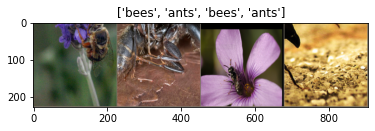

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
print(dataloaders['train'])

In [10]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
# Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
# Finetuning the convnet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
# Train and evaluate

model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.6513 Acc: 0.6721
val Loss: 0.2453 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.6815 Acc: 0.7213
val Loss: 0.3099 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.7743 Acc: 0.7705
val Loss: 0.3401 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5218 Acc: 0.7828
val Loss: 0.3323 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.7564 Acc: 0.7336
val Loss: 0.5079 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4641 Acc: 0.8238
val Loss: 0.3494 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.3966 Acc: 0.8238
val Loss: 0.2270 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3807 Acc: 0.8648
val Loss: 0.2080 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2879 Acc: 0.8689
val Loss: 0.2032 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2804 Acc: 0.8811
val Loss: 0.2259 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3692 Acc: 0.8361
val Loss: 0.2146 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3245 Acc: 0.8607
val Loss: 0.1843 Acc: 0.9477

Ep

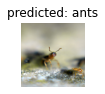

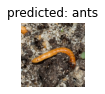

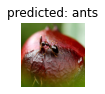

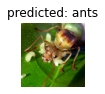

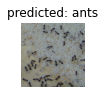

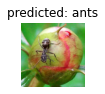

In [14]:
visualize_model(model_ft)